In [90]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [67]:
path_mat = '../../DATA/PLUME_FIG/nose_data.mat'

with h5py.File(path_mat, 'r') as file:
    # List all the groups/variables
    for key in file.keys():
        print(key)

    data = file['nose'][:]  ## data is a series of images

## normalize the data to 0 -> 1
## shift the data so that the minimum value is 0
## divide by the maximum value
data = data - data.min()
data = data / data.max()

## set everything beneath the average to 0
data[data < data.mean()] = 0
## ignoring values that are 0 calculate the new average and standard deviation
## then set everything above the average + 2*std to the average + 2*std
data[data > data[data > 0].mean() + 2*data[data > 0].std()] = data[data > 0].mean() + 2*data[data > 0].std()




nose


In [71]:
std = data.std(axis=0)

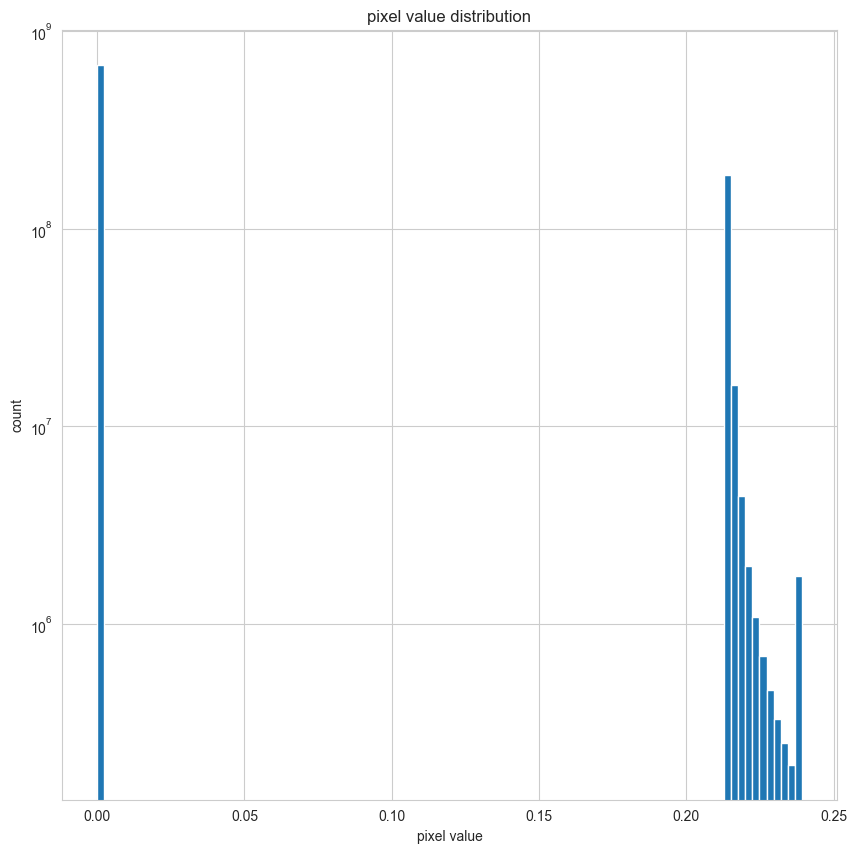

In [68]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist(data.flatten(), bins=100)
ax.set_yscale('log')
ax.set_xlabel('pixel value')
ax.set_ylabel('count')
ax.set_title('pixel value distribution')

plt.show()

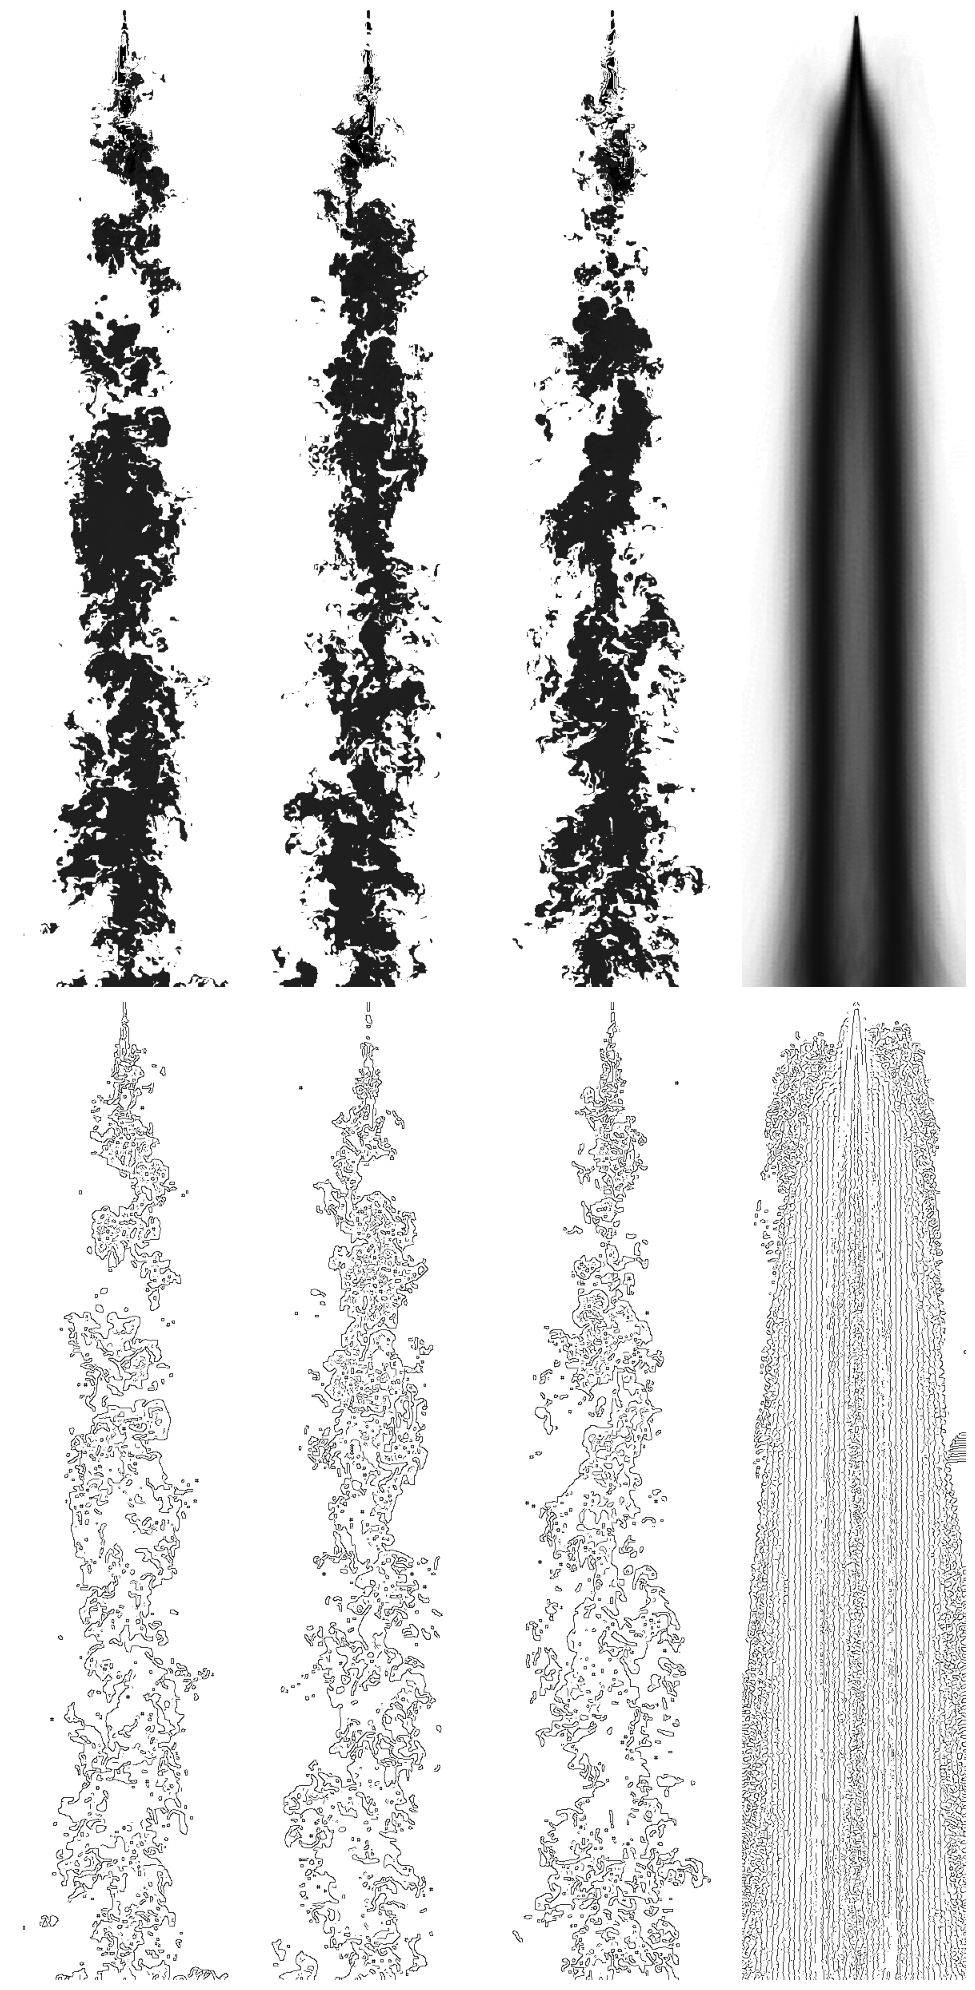

In [92]:
## data is a series of images

## in 4x2 image
## plot the first, middle, last image, and standard deviation of all images
## rotate all images 90 degrees clockwise
## the second row of images are the same images but after having canny edge detection applied

def apply_canny(image, gaussian_kernel=1.25, low_threshold=0.1, high_threshold=0.2):
    image = cv2.convertScaleAbs(image, alpha=255.0/image.max())
    image = cv2.GaussianBlur(image, (5, 5), gaussian_kernel)
    image = cv2.Canny(image, low_threshold, high_threshold)
    return image

cmap = 'Greys'

fig, axs = plt.subplots(2, 4, figsize=(10, 20))

## turn off grid for all plots
## turn of axis ticks for all plots
for ax in axs:
    for a in ax:
        a.grid(False)
        a.set_xticks([])
        a.set_yticks([])
        a.set_aspect('equal')
        ## turn of spines
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.spines['left'].set_visible(False)

axs[0,0].imshow(data[0].T, cmap=cmap, vmin=0, vmax=data.max())
axs[0,1].imshow(data[round(data.shape[0]/2)].T, cmap=cmap)
axs[0,2].imshow(data[-1].T, cmap=cmap)
axs[0,3].imshow(std.T, cmap=cmap)

axs[1,0].imshow(apply_canny(data[0].T), cmap=cmap)
axs[1,1].imshow(apply_canny(data[round(data.shape[0]/2)].T), cmap=cmap)
axs[1,2].imshow(apply_canny(data[-1].T), cmap=cmap)
axs[1,3].imshow(apply_canny(std.T), cmap=cmap)

fig.tight_layout()

path_fig = os.path.join(os.path.dirname(path_mat), 'plumes.png')
fig.savefig(path_fig, dpi=300)

plt.show()
plt.close()

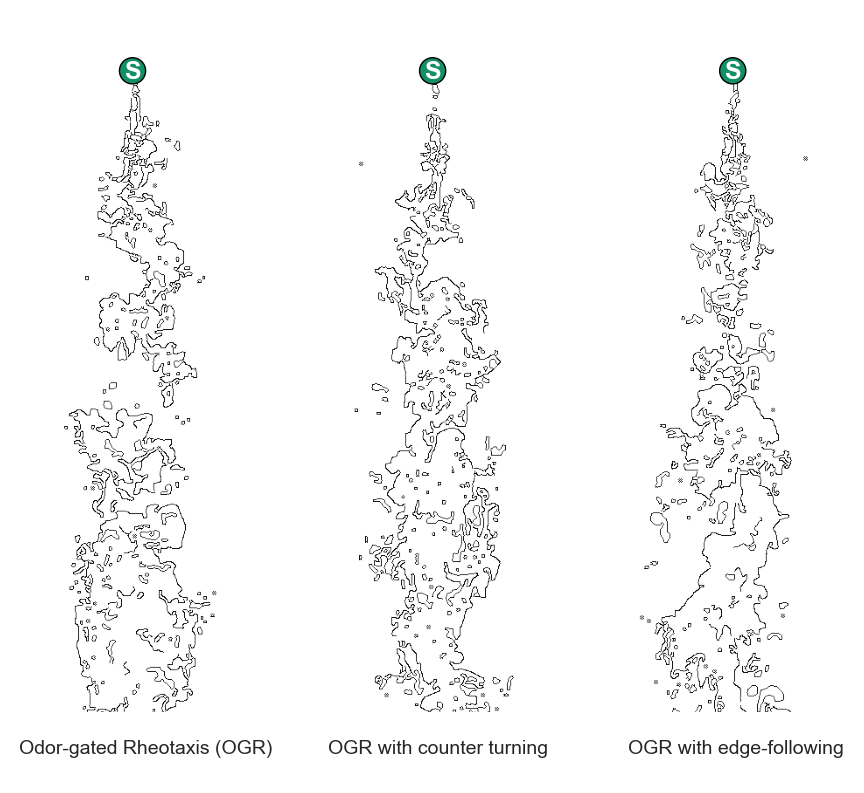

In [223]:
def apply_canny(image, gaussian_kernel=1.25, low_threshold=0.1, high_threshold=0.2, area_fraction=0.5):
    image = cv2.convertScaleAbs(image, alpha=255.0/image.max())
    image = cv2.GaussianBlur(image, (5, 5), gaussian_kernel)
    edges = cv2.Canny(image, low_threshold, high_threshold)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return edges

    # Calculate average contour area
    avg_area = sum([cv2.contourArea(c) for c in contours]) / len(contours)

    # Create an empty black image
    output = np.zeros_like(edges)

    # Draw the largest contour (outer contour) on the output
    cv2.drawContours(output, [contours[0]], -1, 255, 1)

    # Draw only those inner contours that are bigger than a fraction of average area
    for contour in contours[1:]:
        if cv2.contourArea(contour) > area_fraction * avg_area:
            cv2.drawContours(output, [contour], -1, 255, 1)

    return output

## make the above plot, put only plot the second row of images

fig, axs = plt.subplots(1, 3, figsize=(9, 18))

## turn off grid for all plots
## turn of axis ticks for all plots

color_source = '#149066'
## make the hue of the green a little darker

titles_by_ax = ['Odor-gated Rheotaxis (OGR)', 'OGR with counter turning', 'OGR with edge-following']

for i, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ## turn of spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## set ylim to be (data.T.shape[0]*(2/3), 0)
    ax.set_ylim((data.T.shape[0]*(2/3), -70))

    ## draw circle of color source at the bottom middle of the plot with black edges
    ax.add_patch(plt.Circle((data.T.shape[1]/2, 0), 15, facecolor=color_source, edgecolor='black'))

    ## add a white 'S' to the middle of the circle
    ax.text(data.T.shape[1]/2+.2, 2, 'S', color='white', ha='center', va='center', fontsize=18, fontweight='bold')

    ## add title in top left corner
    if i == 0:
        ax.text(10, data.T.shape[0]*(2/3)-50, titles_by_ax[i], ha='left', va='top', fontsize=14, zorder=3)
    else:
        ax.text(20, data.T.shape[0]*(2/3)-50, titles_by_ax[i], ha='left', va='top', fontsize=14, zorder=3)

axs[0].imshow(apply_canny(data[0].T), cmap=cmap, zorder=0)
axs[1].imshow(apply_canny(data[round(data.shape[0]/2)].T), cmap=cmap, zorder=0)
axs[2].imshow(apply_canny(data[-1].T), cmap=cmap, zorder=0)

## add white rectangle to the bottom of the plot
for ax in axs:
    ax.add_patch(plt.Rectangle((-10, data.T.shape[0]*(2/3)-1), data.T.shape[0]-20, -80, facecolor='white', edgecolor='white', zorder=2))

fig.tight_layout(w_pad=0)

path_fig = os.path.join(os.path.dirname(path_mat), '1x3_plumes.png')
fig.savefig(path_fig, dpi=300)

plt.show()
plt.close()